## Logistic Regression with Undersampling

Importing important libraries and modules. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix 
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

%matplotlib inline

Defining the utility function called plot_confusion_matrix for displaying the confusion matrix in a nice UI.

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Defining the utility function called show_data for displaying precision, recall and accuracy from the confusion matrix.

In [3]:
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Accuracy =  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    return tp/(tp+fp), tp/(tp+fn)

Defining Kfol crossvalidator

In [4]:
def kfold_wrapper(X_train, y_train):    
    c_params = [0.01,0.1,1,10,100]
    list_mean_recall = []
    kf = KFold(n_splits=5)
    #print(list(train_index))
    for c in c_params:
        print("-"*50)
        print("C Parameter: ", c)
        itr = 1
        recall_accs = []
        for train_index, val_index in kf.split(X_train):
            lr = LogisticRegression(C = c, penalty = 'l1')
            lr.fit(X_train.iloc[train_index],y_train.iloc[train_index])
            y_pred_undersample = lr.predict(X_train.iloc[val_index])
            recall_acc = recall_score(y_train.iloc[val_index],y_pred_undersample)
            recall_accs.append(recall_acc)
            print("Iteration: ",itr, " Recall Score: ", recall_acc)
            itr+=1
        mean_recall = np.mean(recall_accs)
        print("Mean Recall Score: ", mean_recall)
        list_mean_recall.append(mean_recall)
    recall_c = pd.DataFrame({'c':c_params, 'mean_recall':list_mean_recall})
    display(recall_c)
    best_cparam = recall_c.iloc[recall_c.idxmax()['mean_recall']]['c']
    print("Best C Parameter: ", best_cparam)
    return best_cparam

Loading data from csv file to the dataframe.

In [5]:
data = pd.read_csv('https://people.rit.edu/~hvp4259/project/data/creditcard.csv')
print(data.shape)

(284807, 31)


Separating features from class variables. 

In [12]:
X = data.drop(['Class'], axis=1)
y = data['Class']
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


Extracting fraud data. Also making the undersampled subdataset with entire population of fraud class and same number of non fraud class instances in the undersampled subdataset. 

In [22]:
number_records_fraud = len(data[data.Class == 1])
fraud_record = data[data.Class == 1]
X_fraud_record = fraud_record.drop(['Class'], axis=1)
y_fraud_record = fraud_record['Class']

fraud_indices = np.array(data[data.Class == 1].index)
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.drop(['Class'], axis=1)
y_undersample = under_sample_data['Class']

print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


Splitting training and test data from undersampled subdataset.

In [23]:
# Whole dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#print("Number transactions train dataset: ", len(X_train))
#print("Number transactions test dataset: ", len(X_test))
#print("Total number of transactions: ", len(X_train) + len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample ,y_undersample ,test_size = 0.3 ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample) + len(X_test_undersample))


Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


Training the model and applying the model on test data and ploting the congusion matrix. 

In [24]:
best_c_param = kfold_wrapper(X_train_undersample, y_train_undersample)

--------------------------------------------------
C Parameter:  0.01
Iteration:  1  Recall Score:  0.794520547945
Iteration:  2  Recall Score:  0.821917808219
Iteration:  3  Recall Score:  0.864406779661
Iteration:  4  Recall Score:  0.878378378378
Iteration:  5  Recall Score:  0.893939393939
Mean Recall Score:  0.850632581629
--------------------------------------------------
C Parameter:  0.1
Iteration:  1  Recall Score:  0.849315068493
Iteration:  2  Recall Score:  0.849315068493
Iteration:  3  Recall Score:  0.949152542373
Iteration:  4  Recall Score:  0.918918918919
Iteration:  5  Recall Score:  0.893939393939
Mean Recall Score:  0.892128198443
--------------------------------------------------
C Parameter:  1
Iteration:  1  Recall Score:  0.86301369863
Iteration:  2  Recall Score:  0.904109589041
Iteration:  3  Recall Score:  0.966101694915
Iteration:  4  Recall Score:  0.945945945946
Iteration:  5  Recall Score:  0.878787878788
Mean Recall Score:  0.911591761464
---------------

,c,mean_recall
0,0.01,0.850633
1,0.10,0.892128
2,1.00,0.911592
3,10.00,0.920392
4,100.00,0.920392


Best C Parameter:  10.0


[[145   4]
 [ 11 136]]


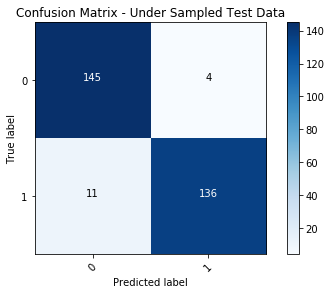

Precision =     0.971
Recall (TPR) =  0.925
Accuracy =  0.949


In [25]:
lr = LogisticRegression(C = best_c_param, penalty = 'l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, ['0', '1'], title = 'Confusion Matrix - Under Sampled Test Data')
pr, tpr = show_data(cnf_matrix, print_res = 1);

Applying the model on fraud data only and ploting the congusion matrix. 

[[  0   0]
 [ 42 450]]


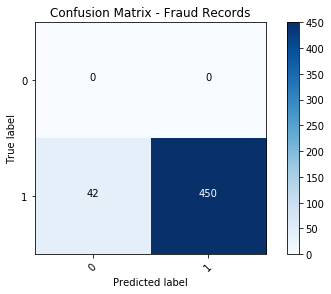

Precision =     1.000
Recall (TPR) =  0.915
Accuracy =  0.915


In [26]:
#lr = LogisticRegression(C = 0.01, penalty = 'l2')
#lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_fraud_record = lr.predict(X_fraud_record)

cnf_matrix = confusion_matrix(y_fraud_record, y_pred_fraud_record)
np.set_printoptions(precision=2)

print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, ['0', '1'], title = 'Confusion Matrix - Fraud Records')
pr, tpr = show_data(cnf_matrix, print_res = 1);

Applying the model on entire dataset and plotting the confusion matrix. 

[[275264   9051]
 [    42    450]]


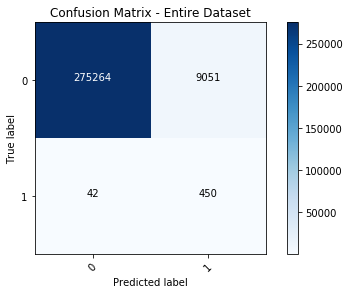

Precision =     0.047
Recall (TPR) =  0.915
Accuracy =  0.968


In [27]:
#lr = LogisticRegression(C = 0.01, penalty = 'l2')
#lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_all = lr.predict(X.values)

cnf_matrix = confusion_matrix(y, y_pred_all)
np.set_printoptions(precision=2)

print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, ['0', '1'], title = 'Confusion Matrix - Entire Dataset')
pr, tpr = show_data(cnf_matrix, print_res = 1);